## 🧠 Convolutional Neural Network (CNN)

This notebook demonstrates how to build, train, and evaluate a **Convolutional Neural Network (CNN)** using **PyTorch** in the context of **machine reliability and maintenance**.

We will:
1. Simulate a small **synthetic 2D sensor dataset** representing vibration-temperature maps.
2. Build and train a CNN classifier to predict **Faulty** vs **Healthy** machines.
3. Evaluate the model (accuracy, confusion matrix, and loss curve).
4. Discuss how CNNs apply to real maintenance data such as thermal images or vibration spectrograms.

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

### 1️⃣ Create a Synthetic Dataset

We will generate artificial **8x8 grayscale sensor maps**:
- **Healthy machines**: lower intensity, smooth readings.
- **Faulty machines**: higher intensity, noisy readings.

Each sample will be treated like a small image for CNN processing.

In [2]:
class SyntheticMachineDataset(Dataset):
    def __init__(self, n_samples=400):
        self.data, self.labels = [], []
        for _ in range(n_samples):
            if np.random.rand() > 0.5:
                # Faulty sample: higher intensity, noisy pattern
                base = np.random.normal(0.7, 0.1, (8, 8))
                label = 1
            else:
                # Healthy sample: lower intensity, smooth pattern
                base = np.random.normal(0.3, 0.1, (8, 8))
                label = 0
            base = np.clip(base, 0, 1)
            self.data.append(base.astype(np.float32))
            self.labels.append(label)
        self.data = np.expand_dims(np.array(self.data), axis=1)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create dataset
dataset = SyntheticMachineDataset(n_samples=400)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f'Train size: {len(train_dataset)}, Test size: {len(test_dataset)}')

Train size: 320, Test size: 80


### 2️⃣ Define the CNN Model

We'll define a **simple CNN** with two convolutional layers, ReLU activations, max-pooling, and a fully connected layer.

In [3]:
class MachineCNN(nn.Module):
    def __init__(self):
        super(MachineCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 2 * 2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 2 * 2)
        x = self.fc1(x)
        return x

model = MachineCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 3️⃣ Train the Model

Epoch 1/15, Loss: 0.6646
Epoch 2/15, Loss: 0.6230
Epoch 3/15, Loss: 0.5679
Epoch 4/15, Loss: 0.4935
Epoch 5/15, Loss: 0.4041
Epoch 6/15, Loss: 0.3101
Epoch 7/15, Loss: 0.2197
Epoch 8/15, Loss: 0.1369
Epoch 9/15, Loss: 0.0794
Epoch 10/15, Loss: 0.0434
Epoch 11/15, Loss: 0.0245
Epoch 12/15, Loss: 0.0145
Epoch 13/15, Loss: 0.0096
Epoch 14/15, Loss: 0.0069
Epoch 15/15, Loss: 0.0052


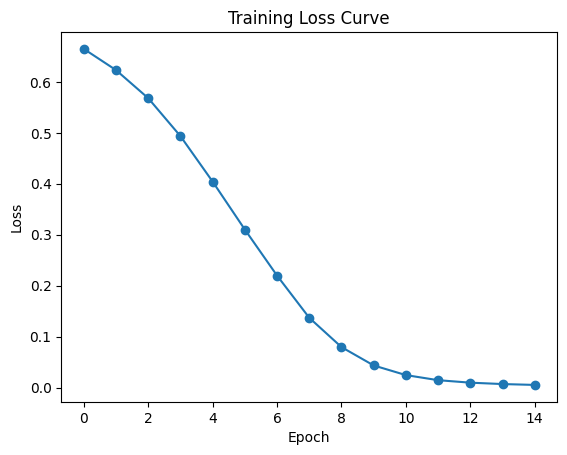

In [4]:
n_epochs = 15
train_losses = []

for epoch in range(n_epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {train_losses[-1]:.4f}')

plt.plot(train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### 4️⃣ Evaluate Model Performance

Test Accuracy: 100.00%


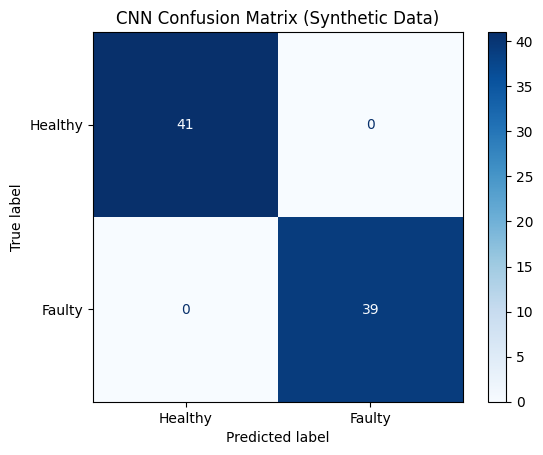

In [5]:
model.eval()
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Healthy','Faulty']).plot(cmap='Blues')
plt.title('CNN Confusion Matrix (Synthetic Data)')
plt.show()

### 5️⃣ Key Insights

- The CNN effectively distinguishes **healthy** and **faulty** patterns in synthetic sensor data.
- CNNs can learn **spatial correlations** from vibration, temperature, and acoustic maps.
- In real maintenance tasks, CNNs are used for:
  - Infrared thermal images (detect overheating)
  - Vibration spectrograms (detect bearing faults)
  - Acoustic images (detect air leaks or motor wear).

### ✅ Summary
- **CNNs** are powerful for detecting patterns in 2D sensor data.
- **Healthy vs Faulty** classification can use spatial sensor representations.
- This example shows the foundation for real-world predictive maintenance applications using PyTorch.